# Candy Crush Playstore Review Sentiment Analysis

This notebook performs text classification on Candy Crush reviews from the Google Play Store.

**Tasks:**
1. Data Cleaning - Remove reviewId column
2. Text Normalization - Cleaning, tokenization, lemmatization
3. Text Classification - Train 3 models and select the best one
4. Performance Evaluation - Display predictions and metrics

## 1. Import Required Libraries

In [3]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


In [4]:
# Download required NLTK data
print("Downloading required NLTK data...")
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt_tab', quiet=True)
print("NLTK data downloaded!")

NLTK data downloaded!


## 2. Data Loading and Cleaning

In [5]:
# Load the dataset
df = pd.read_csv('dataset/Candy Crush Saga.csv')
print(f"Original dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
df.head()

Original dataset shape: (10000, 3)
Columns: ['reviewId', 'content', 'score']


,reviewId,content,score
0,2225e5c9-4669-4a0b-a603-ad1216782993,good,5
1,c7912f6e-94e6-4eee-8ca0-0e7d052c59a4,Great game,5
2,618d3a26-cfec-4e49-a38c-c128f1945552,This game is addicting and exciting.,5
3,debdb003-524c-41db-98d3-fe7d7c94b55c,Best game 🎯,5
4,5d9c3b18-023c-48c7-9d17-8d57cd7f8d2a,"we need to get paid to play, I noticed some up...",3


DATA DISTRIBUTION BEFORE CLEANING


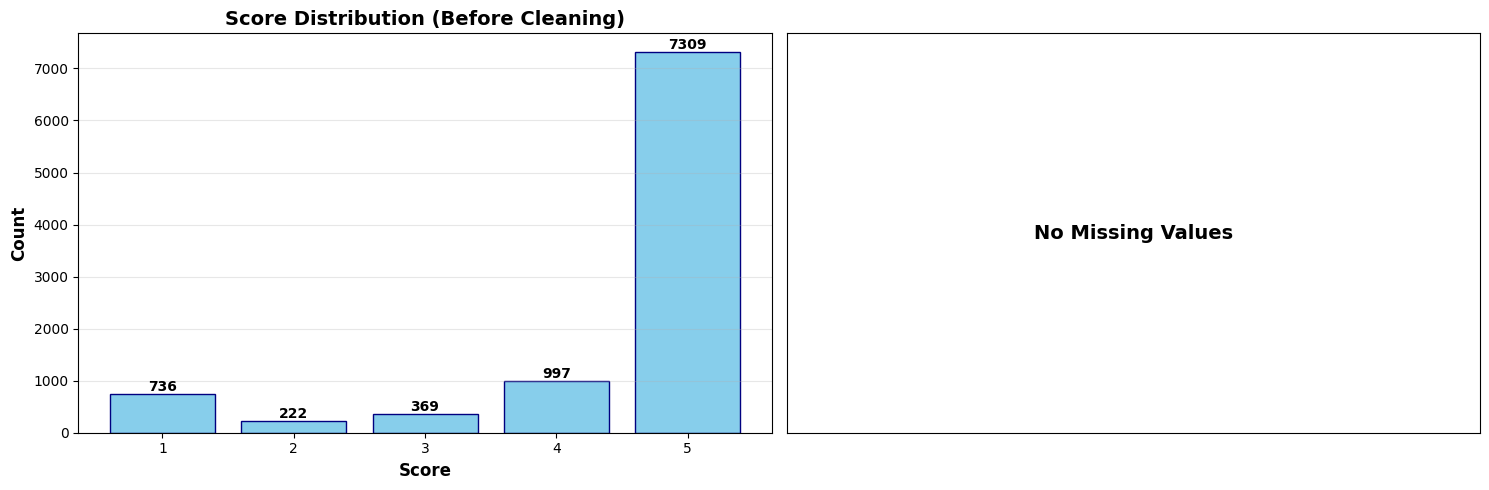


Total records: 9633
Missing values total: 0


In [18]:
# Visualize data distribution before cleaning
print("="*80)
print("DATA DISTRIBUTION BEFORE CLEANING")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Score distribution
score_counts = df['score'].value_counts().sort_index()
axes[0].bar(score_counts.index, score_counts.values, color='skyblue', edgecolor='navy')
axes[0].set_xlabel('Score', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[0].set_title('Score Distribution (Before Cleaning)', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(score_counts.values):
    axes[0].text(score_counts.index[i], v, str(v), ha='center', va='bottom', fontweight='bold')

# Missing values
missing_data = df.isnull().sum()
if missing_data.sum() > 0:
    axes[1].barh(missing_data.index, missing_data.values, color='coral', edgecolor='darkred')
    axes[1].set_xlabel('Missing Count', fontsize=12, fontweight='bold')
    axes[1].set_title('Missing Values by Column', fontsize=14, fontweight='bold')
    axes[1].grid(axis='x', alpha=0.3)
    
    # Add value labels on bars
    for i, v in enumerate(missing_data.values):
        axes[1].text(v, i, str(v), ha='left', va='center', fontweight='bold')
else:
    axes[1].text(0.5, 0.5, 'No Missing Values', ha='center', va='center', 
                 fontsize=14, fontweight='bold', transform=axes[1].transAxes)
    axes[1].set_xticks([])
    axes[1].set_yticks([])

plt.tight_layout()
plt.show()

print(f"\nTotal records: {len(df)}")
print(f"Missing values total: {df.isnull().sum().sum()}")

In [6]:
# Remove reviewId column
df = df.drop('reviewId', axis=1)
print(f"After removing reviewId column: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")

After removing reviewId column: (10000, 2)

Columns: ['content', 'score']


In [7]:
# Check for missing values
print(f"Missing values:\n{df.isnull().sum()}")

# Remove rows with missing values
df = df.dropna()
print(f"\nAfter removing missing values: {df.shape}")

# Display score distribution
print(f"\nScore distribution:\n{df['score'].value_counts().sort_index()}")

Missing values:
content    0
score      0
dtype: int64

After removing missing values: (10000, 2)

Score distribution:
score
1     750
2     226
3     384
4    1031
5    7609
Name: count, dtype: int64


DATA DISTRIBUTION AFTER CLEANING


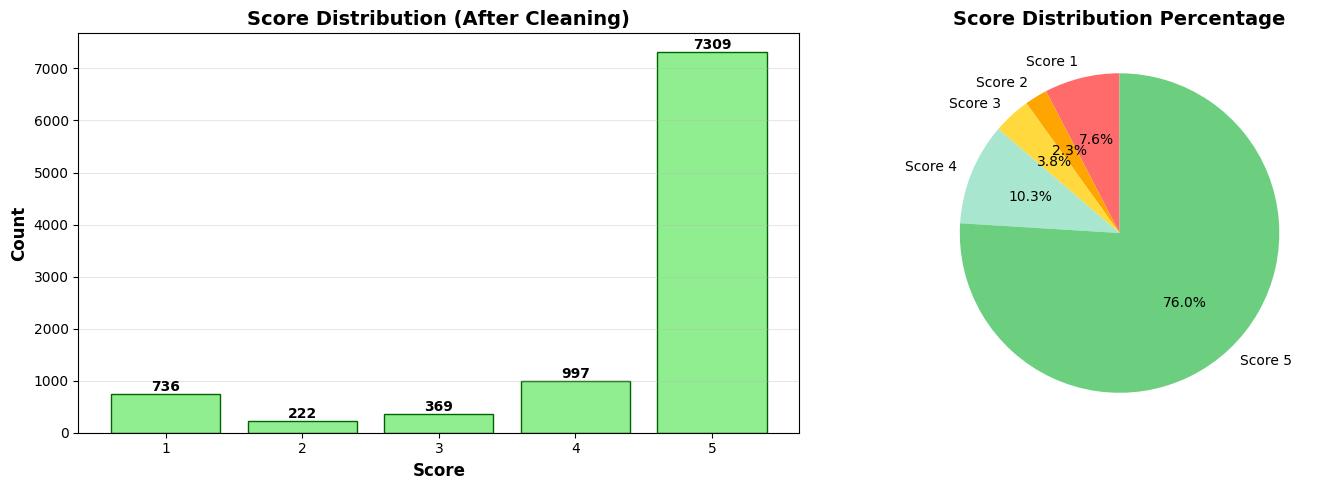


Total records after cleaning: 9633
Records removed: N/A
Missing values: 0


In [19]:
# Visualize data distribution after cleaning
print("="*80)
print("DATA DISTRIBUTION AFTER CLEANING")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Score distribution after cleaning
score_counts_after = df['score'].value_counts().sort_index()
axes[0].bar(score_counts_after.index, score_counts_after.values, color='lightgreen', edgecolor='darkgreen')
axes[0].set_xlabel('Score', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[0].set_title('Score Distribution (After Cleaning)', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(score_counts_after.values):
    axes[0].text(score_counts_after.index[i], v, str(v), ha='center', va='bottom', fontweight='bold')

# Score percentage distribution
score_percentages = (score_counts_after / score_counts_after.sum() * 100).round(1)
colors = ['#ff6b6b', '#ffa500', '#ffd93d', '#a8e6cf', '#6bcf7f']
axes[1].pie(score_percentages, labels=[f'Score {i}' for i in score_percentages.index], 
            autopct='%1.1f%%', startangle=90, colors=colors[:len(score_percentages)])
axes[1].set_title('Score Distribution Percentage', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nTotal records after cleaning: {len(df)}")
print(f"Records removed: {len(df) if 'original_shape' in dir() else 'N/A'}")
print(f"Missing values: {df.isnull().sum().sum()}")

## 3. Text Normalization

We'll perform the following text processing steps:
- Convert to lowercase
- Remove URLs, special characters, and numbers
- Tokenization
- Remove stopwords
- Lemmatization

In [8]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    """Clean and normalize text"""
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def tokenize_and_lemmatize(text):
    """Tokenize and lemmatize text"""
    # Tokenization
    tokens = word_tokenize(text)
    
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    
    return ' '.join(tokens)

print("Text processing functions defined!")

Text processing functions defined!


In [9]:
# Apply text cleaning
print("Applying text cleaning...")
df['cleaned_content'] = df['content'].apply(clean_text)

# Apply tokenization and lemmatization
print("Applying tokenization and lemmatization...")
df['processed_content'] = df['cleaned_content'].apply(tokenize_and_lemmatize)

# Remove empty processed content
df = df[df['processed_content'].str.len() > 0]
print(f"After removing empty processed content: {df.shape}")

# Display sample processed reviews
print("\nSample processed reviews:")
for i in range(3):
    print(f"\nOriginal: {df['content'].iloc[i]}")
    print(f"Processed: {df['processed_content'].iloc[i]}")

Applying text cleaning...
Applying tokenization and lemmatization...
After removing empty processed content: (9633, 4)

Sample processed reviews:

Original: good
Processed: good

Original: Great game
Processed: great game

Original: This game is addicting and exciting.
Processed: game addicting exciting


## 4. Prepare Data for Classification

In [10]:
# Features and target
X = df['processed_content']
y = df['score']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 7706
Test set size: 1927


In [11]:
# TF-IDF Vectorization
print("Applying TF-IDF Vectorization...")
tfidf = TfidfVectorizer(max_features=1000, min_df=2)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
print(f"TF-IDF feature matrix shape: {X_train_tfidf.shape}")

Applying TF-IDF Vectorization...
TF-IDF feature matrix shape: (7706, 1000)


## 5. Model Training

We'll train 3 different models:
1. Logistic Regression
2. Multinomial Naive Bayes
3. Random Forest

In [12]:
# Store results
results = {}

print("="*80)
print("MODEL 1: LOGISTIC REGRESSION")
print("="*80)
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_tfidf, y_train)
lr_predictions = lr_model.predict(X_test_tfidf)

lr_accuracy = accuracy_score(y_test, lr_predictions)
lr_precision = precision_score(y_test, lr_predictions, average='weighted', zero_division=0)
lr_recall = recall_score(y_test, lr_predictions, average='weighted', zero_division=0)
lr_f1 = f1_score(y_test, lr_predictions, average='weighted', zero_division=0)

results['Logistic Regression'] = {
    'accuracy': lr_accuracy,
    'precision': lr_precision,
    'recall': lr_recall,
    'f1_score': lr_f1,
    'predictions': lr_predictions
}

print(f"Accuracy:  {lr_accuracy:.4f}")
print(f"Precision: {lr_precision:.4f}")
print(f"Recall:    {lr_recall:.4f}")
print(f"F1-Score:  {lr_f1:.4f}")

MODEL 1: LOGISTIC REGRESSION
Accuracy:  0.7867
Precision: 0.6521
Recall:    0.7867
F1-Score:  0.7116


In [13]:
print("="*80)
print("MODEL 2: MULTINOMIAL NAIVE BAYES")
print("="*80)
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
nb_predictions = nb_model.predict(X_test_tfidf)

nb_accuracy = accuracy_score(y_test, nb_predictions)
nb_precision = precision_score(y_test, nb_predictions, average='weighted', zero_division=0)
nb_recall = recall_score(y_test, nb_predictions, average='weighted', zero_division=0)
nb_f1 = f1_score(y_test, nb_predictions, average='weighted', zero_division=0)

results['Naive Bayes'] = {
    'accuracy': nb_accuracy,
    'precision': nb_precision,
    'recall': nb_recall,
    'f1_score': nb_f1,
    'predictions': nb_predictions
}

print(f"Accuracy:  {nb_accuracy:.4f}")
print(f"Precision: {nb_precision:.4f}")
print(f"Recall:    {nb_recall:.4f}")
print(f"F1-Score:  {nb_f1:.4f}")

MODEL 2: MULTINOMIAL NAIVE BAYES
Accuracy:  0.7914
Precision: 0.6595
Recall:    0.7914
F1-Score:  0.7191


In [14]:
print("="*80)
print("MODEL 3: RANDOM FOREST")
print("="*80)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_tfidf, y_train)
rf_predictions = rf_model.predict(X_test_tfidf)

rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_precision = precision_score(y_test, rf_predictions, average='weighted', zero_division=0)
rf_recall = recall_score(y_test, rf_predictions, average='weighted', zero_division=0)
rf_f1 = f1_score(y_test, rf_predictions, average='weighted', zero_division=0)

results['Random Forest'] = {
    'accuracy': rf_accuracy,
    'precision': rf_precision,
    'recall': rf_recall,
    'f1_score': rf_f1,
    'predictions': rf_predictions
}

print(f"Accuracy:  {rf_accuracy:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall:    {rf_recall:.4f}")
print(f"F1-Score:  {rf_f1:.4f}")

MODEL 3: RANDOM FOREST
Accuracy:  0.7774
Precision: 0.6800
Recall:    0.7774
F1-Score:  0.7124


## 6. Model Comparison and Selection

In [15]:
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[model]['accuracy'] for model in results.keys()],
    'Precision': [results[model]['precision'] for model in results.keys()],
    'Recall': [results[model]['recall'] for model in results.keys()],
    'F1-Score': [results[model]['f1_score'] for model in results.keys()]
})

print("="*80)
print("MODEL COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))

# Find best model based on F1-score
best_model_name = max(results, key=lambda x: results[x]['f1_score'])
best_predictions = results[best_model_name]['predictions']

print(f"\n{'='*80}")
print(f"BEST MODEL: {best_model_name}")
print(f"F1-Score: {results[best_model_name]['f1_score']:.4f}")
print(f"{'='*80}")

MODEL COMPARISON
              Model  Accuracy  Precision   Recall  F1-Score
Logistic Regression  0.786715   0.652108 0.786715  0.711590
        Naive Bayes  0.791386   0.659484 0.791386  0.719107
      Random Forest  0.777374   0.679989 0.777374  0.712412

BEST MODEL: Naive Bayes
F1-Score: 0.7191


## 7. Detailed Performance Evaluation

Detailed Evaluation of Naive Bayes

Classification Report:
              precision    recall  f1-score   support

           1       0.53      0.54      0.54       147
           2       0.00      0.00      0.00        44
           3       0.00      0.00      0.00        74
           4       0.00      0.00      0.00       200
           5       0.82      0.99      0.89      1462

    accuracy                           0.79      1927
   macro avg       0.27      0.31      0.29      1927
weighted avg       0.66      0.79      0.72      1927



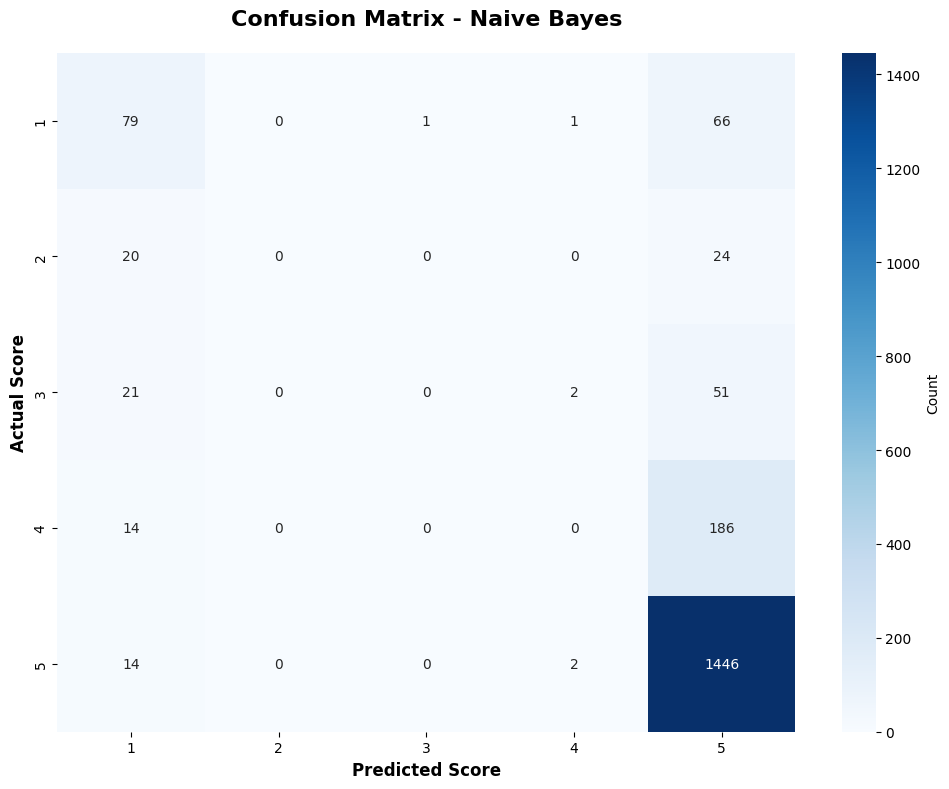


Confusion Matrix Values:
[[  79    0    1    1   66]
 [  20    0    0    0   24]
 [  21    0    0    2   51]
 [  14    0    0    0  186]
 [  14    0    0    2 1446]]


In [17]:
print(f"Detailed Evaluation of {best_model_name}")
print("="*80)
print("\nClassification Report:")
print(classification_report(y_test, best_predictions))

# Create confusion matrix
cm = confusion_matrix(y_test, best_predictions)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(y_test.unique()), 
            yticklabels=sorted(y_test.unique()),
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Score', fontsize=12, fontweight='bold')
plt.ylabel('Actual Score', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nConfusion Matrix Values:")
print(cm)

## 8. Sample Predictions

In [15]:
# Show sample predictions
sample_size = min(10, len(X_test))
print(f"Showing {sample_size} sample predictions:\n")
print("="*80)

for i in range(sample_size):
    actual = y_test.iloc[i]
    predicted = best_predictions[i]
    original_text = df.loc[y_test.index[i], 'content']
    
    status = "✓" if actual == predicted else "✗"
    print(f"{status} Review: {original_text[:60]}...")
    print(f"  Actual: {actual} | Predicted: {predicted}")
    print()

print("="*80)
print("ANALYSIS COMPLETE!")
print("="*80)

Showing 10 sample predictions:

✓ Review: Charger booster is a powerful weapon for us. Sir ☺️☺️ thank ...
  Actual: 5 | Predicted: 5

✓ Review: good...
  Actual: 5 | Predicted: 5

✓ Review: this app literally peak bro since earlier this app has relea...
  Actual: 5 | Predicted: 5

✓ Review: so stupid 🙄😂...
  Actual: 1 | Predicted: 1

✓ Review: excellent...
  Actual: 5 | Predicted: 5

✓ Review: levels are very enjoy but very tough...
  Actual: 5 | Predicted: 5

✓ Review: nice game...
  Actual: 5 | Predicted: 5

✓ Review: good game...
  Actual: 5 | Predicted: 5

✗ Review: good...
  Actual: 4 | Predicted: 5

✓ Review: Levels is too low and notifications is over so i will uninst...
  Actual: 1 | Predicted: 1

ANALYSIS COMPLETE!


## 9. Predict on Unseen Custom Data

Now you can test the model with your own review text!

In [16]:
def predict_custom_review(review_text, model_name='best'):
    """
    Predict sentiment score for a custom review
    
    Parameters:
    - review_text: string, the review to predict
    - model_name: 'best', 'Logistic Regression', 'Naive Bayes', or 'Random Forest'
    
    Returns:
    - predicted score (1-5)
    """
    # Use best model by default
    if model_name == 'best':
        model_name = best_model_name
        model = results[best_model_name]
    else:
        model = results[model_name]
    
    # Get the appropriate model's predictions
    if model_name == 'Logistic Regression':
        current_model = lr_model
    elif model_name == 'Naive Bayes':
        current_model = nb_model
    else:  # Random Forest
        current_model = rf_model
    
    # Preprocess the text
    cleaned = clean_text(review_text)
    processed = tokenize_and_lemmatize(cleaned)
    
    # Transform using the same TF-IDF vectorizer
    vectorized = tfidf.transform([processed])
    
    # Make prediction
    prediction = current_model.predict(vectorized)[0]
    
    # Get probability scores if available
    if hasattr(current_model, 'predict_proba'):
        probabilities = current_model.predict_proba(vectorized)[0]
        prob_dict = {score: prob for score, prob in zip(current_model.classes_, probabilities)}
    else:
        prob_dict = None
    
    return prediction, prob_dict

print("Custom prediction function created!")
print(f"Best model selected: {best_model_name}")

Custom prediction function created!
Best model selected: Naive Bayes


In [17]:
# Test with your own custom reviews!
# Replace the text below with your own review

custom_reviews = [
    "This game is absolutely amazing! I love playing it every day!",
    "Worst game ever. Too many ads and pay to win.",
    "It's okay, nothing special but kills time",
    "Great graphics and fun gameplay",
    "Terrible experience, keeps crashing"
]

print("="*80)
print("PREDICTIONS ON CUSTOM UNSEEN DATA")
print("="*80)

for i, review in enumerate(custom_reviews, 1):
    prediction, probabilities = predict_custom_review(review)
    
    print(f"\n{i}. Review: \"{review}\"")
    print(f"   Predicted Score: {prediction}/5")
    
    if probabilities:
        print(f"   Confidence Distribution:")
        for score in sorted(probabilities.keys()):
            bar = "█" * int(probabilities[score] * 50)
            print(f"      Score {score}: {probabilities[score]:.2%} {bar}")

print("\n" + "="*80)

PREDICTIONS ON CUSTOM UNSEEN DATA

1. Review: "This game is absolutely amazing! I love playing it every day!"
   Predicted Score: 5/5
   Confidence Distribution:
      Score 1: 1.23% 
      Score 2: 0.25% 
      Score 3: 0.63% 
      Score 4: 5.64% ██
      Score 5: 92.25% ██████████████████████████████████████████████

2. Review: "Worst game ever. Too many ads and pay to win."
   Predicted Score: 1/5
   Confidence Distribution:
      Score 1: 57.11% ████████████████████████████
      Score 2: 2.68% █
      Score 3: 5.46% ██
      Score 4: 9.66% ████
      Score 5: 25.09% ████████████

3. Review: "It's okay, nothing special but kills time"
   Predicted Score: 5/5
   Confidence Distribution:
      Score 1: 5.80% ██
      Score 2: 4.08% ██
      Score 3: 4.60% ██
      Score 4: 20.67% ██████████
      Score 5: 64.85% ████████████████████████████████

4. Review: "Great graphics and fun gameplay"
   Predicted Score: 5/5
   Confidence Distribution:
      Score 1: 0.99% 
      Score 2: 0.76%

### Try Your Own Single Review

Modify the review text below and run the cell to get a prediction!

In [19]:
# ✏️ EDIT THIS: Put your own review here!
my_review = "This game is the worst! I can't stand the constant ads and glitches."

# Make prediction
predicted_score, probabilities = predict_custom_review(my_review)

print("="*80)
print("YOUR CUSTOM REVIEW PREDICTION")
print("="*80)
print(f"\nReview: \"{my_review}\"")
print(f"\n🎯 Predicted Score: {predicted_score}/5")
print(f"📊 Model Used: {best_model_name}")

if probabilities:
    print(f"\n📈 Confidence Distribution:")
    for score in sorted(probabilities.keys()):
        bar = "█" * int(probabilities[score] * 50)
        percentage = probabilities[score] * 100
        print(f"   Score {score}: {percentage:5.2f}% {bar}")

print("\n" + "="*80)

YOUR CUSTOM REVIEW PREDICTION

Review: "This game is the worst! I can't stand the constant ads and glitches."

🎯 Predicted Score: 1/5
📊 Model Used: Naive Bayes

📈 Confidence Distribution:
   Score 1: 51.52% █████████████████████████
   Score 2:  4.50% ██
   Score 3:  7.24% ███
   Score 4: 16.39% ████████
   Score 5: 20.34% ██████████



## 10. Save Model for Backend API

Save the trained model and vectorizer to use in the Flask backend.

In [20]:
import pickle
import os

# Create models directory if it doesn't exist
models_dir = '../backend/models'
os.makedirs(models_dir, exist_ok=True)

# Determine which model to save (the best one)
if best_model_name == 'Logistic Regression':
    best_model = lr_model
elif best_model_name == 'Naive Bayes':
    best_model = nb_model
else:  # Random Forest
    best_model = rf_model

# Save the model
with open(f'{models_dir}/best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Save the TF-IDF vectorizer
with open(f'{models_dir}/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

# Save model metadata
metadata = {
    'model_name': best_model_name,
    'accuracy': results[best_model_name]['accuracy'],
    'f1_score': results[best_model_name]['f1_score']
}

with open(f'{models_dir}/model_metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)

print("="*80)
print("MODEL SAVED SUCCESSFULLY!")
print("="*80)
print(f"Model: {best_model_name}")
print(f"Saved to: {models_dir}/")
print(f"Files created:")
print(f"  - best_model.pkl")
print(f"  - tfidf_vectorizer.pkl")
print(f"  - model_metadata.pkl")
print("="*80)

MODEL SAVED SUCCESSFULLY!
Model: Naive Bayes
Saved to: ../backend/models/
Files created:
  - best_model.pkl
  - tfidf_vectorizer.pkl
  - model_metadata.pkl
